# Craigslist House Price Crawling with Scrapy and Trend Analysis

## Introduction

This tutorial will show you how to write a crawler with Scrapy to scrape Craigslist Housing prices in San Francisco and store the data in a CSV file. Then I will include steps to plot the trend of house price varied in one year and make some simple analysis. 

Craigslist is a classified advertisements website with sections devoted to jobs, housing, personals, for sale etc. There are 2500 apt/housing for rent on Craigslist in San Francisco and around bay area. The dataset for this project is the location and price of these 2500 houses/apt.

## Tutorial content
The rest of this wiki gives a detailed description of the following parts:
1. [Installing Scrapy](#Installing-Scrapy)
2. [Declaring Items](#Declaring-Items)
3. [Write Spider](#Write-Spider)
4. [Result analysis and Data visualization](#Result-Analysis-and-Data-visualization)

## Installing Scrapy

Scrapy runs on Python 2.7 and Python 3.3 or above (except on Windows where Python 3 is not supported yet). You can install Scrapy and its dependencies from PyPI with:

    $ pip install Scrapy
    
After the installation, you can see notification like:

&nbsp;&nbsp;&nbsp;&nbsp;*Successfully installed PyDispatcher-2.0.5 Scrapy-1.2.0 Twisted...* 

in terminal, which means Scrapy is installed sucessfully.

## Declaring Items

Craigslist web page we are crawling is unstructured sources, however to make it easier to analysis, we need to extract structured data from the raw data. Scrapy spiders can return the extracted data as Python dicts by default. While convenient and familiar, Python dicts lack structure: it is easy to make a typo in a field name or return inconsistent data, especially in a larger project with many spiders.

To define common output data format Scrapy provides the Item class. Items are containers that will be loaded with the scraped data; they work like simple python dicts but provide additional protection against populating undeclared fields, to prevent typos. Items are declared using a simple class definition syntax and Field objects. 

Before coding, first thing we need to clarify is what information is needed and declare items according to these objects. Here we need datetime when the post is published, price of the house, detailed location and house type. Thus items are created like below:

In [ ]:
import re
from scrapy.item import Item, Field


def room_serialize(content):
    res = ""
    if len(content) == 0:
        return res
    expbr = re.compile(r'\d+br')
    bed = expbr.search(content[0])
    if bed is not None:
        res = bed.group(0)[:-2]
    return res


def area_serialize(content):
    res = ""
    if len(content) == 0:
        return res
    expft = re.compile(r'\d+ft')
    ft = expft.search(content[0])
    if ft is not None:
        res = ft.group(0)
    return res


class CraigslistItem(Item):
    datetime = Field()
    price = Field()
    location = Field()
    room = Field(serializer=room_serialize)
    area = Field(serializer=area_serialize)


Since room and area field metadata sometimes are empty or in wrong format, I extend these two items to add specific serializer to change some metadata to make the result suitable for analysis. 

## Write Spider

Spiders are user-written classes used to scrape information from a domain (or group of domains). Most logic management is defined inside of Spider. Spider can define how to crawl the website, what data to extract and return the structured items. 

Basic spider class inherits from BaseSpider. However, this will only crawl on one page. We need to scray Web Pages recursively to enable spider to click *next button* to crawl data on all pages. Then in this tutorial spider needs to inherit from CrawlSpider class. 

We need to add in some Rules objects to define how the crawler follows the links. In craigslist housing, there are only 100 posts in one page and we need to click on next button to do the recursive crawl.

When spider get one valid page, this will be treated as *response* then sent to *parse_items* function. 

### XPath Selectors

XPath is a language for selecting nodes in XML documents, which can also be used with HTML. It is very powerful and flexible and supported by many extraction tools nowadays. In this tutorial, two larger div: times and infos are extracted at first. This acts as a nesting selector, then a further extract using XPath is needed to get more specific data inside times and infos div.

In [ ]:
from scrapy.contrib.spiders import CrawlSpider, Rule
from scrapy.contrib.linkextractors.sgml import SgmlLinkExtractor
from scrapy.selector import HtmlXPathSelector
from craigslist.items import CraigslistItem


class MySpider(CrawlSpider):
    name = "craigs"
    allowed_domains = ["sfbay.craigslist.org"]
    start_urls = ["https://sfbay.craigslist.org/search/apa"]

    rules = (
        Rule(SgmlLinkExtractor(allow=(), restrict_xpaths=('//a[@class="button next"]',)), callback="parse_items",
             follow=True),
    )

    def parse_items(self, response):
        hxs = HtmlXPathSelector(response)
        times = hxs.xpath('//span[@class="pl"]')
        infos = hxs.xpath('//span[@class="l2"]')
        items = []
        for time, info in zip(times, infos):
            item = CraigslistItem()
            item["datetime"] = time.xpath('time/@datetime').extract()
            item["price"] = info.xpath('span[@class="price"]/text()').extract()
            if len(item["datetime"]) == 0 or len(item["price"]) == 0:
                continue
            item["location"] = info.xpath('span[@class="pnr"]/small/text()').extract()
            item["room"] = info.xpath('span[@class="housing"]/text()').extract()
            item["area"] = info.xpath('span[@class="housing"]/text()').extract()
            items.append(item)
        return items
   

* Allowed_domains are domains that spider is allowed to crawl. This is an optional part, but including it can avoid to crawl other unrelative pages if there are some links on the start page.

* SgmlLinkExtractor defines how the spider will follow the links: allow defines the link href, restrict_xpaths retricts the links to a certain Xpath.

* Callback defines which function to call after each page is scraped. 

* Follow defines whether to continue following the links as long as they exists. 

### CSS Selector
CSS selectors are patterns used to select the element(s) you want to style. In the background, CSS queries are translated into XPath queries using cssselect library and run .xpath() method. CSS selectors are great, and they’re constantly rolling out new and better features that make them greater, they were still specifically designed for styling.

In [ ]:
    def parse_items_css(self, response):
        times = response.css('span.pl')
        infos = response.css('span.l2')
        items = []
        for time, info in zip(times, infos):
            item = CraigslistItem()
            item["datetime"] = time.css('time::attr("datetime")').extract()
            item["price"] = info.css('span.price::text').extract()
            item["location"] = info.css('span.pnr small::text').extract()
            item["room"] = info.css('span.housing::text').extract()
            if len(item["datetime"]) == 0 or len(item["price"]) == 0 or len(item["room"]) == 0:
                continue
            item["area"] = info.css('span.housing::text').extract()
            items.append(item)
        return items

Explanation for the code above.

In the CSS query, *time::attr("datetime")* will extract datetime attribute under time class.

*span.pnr small::text* will find the span with pnr class type, then the inner class named small and extract its text.

### note

To run the above spider, shoot the following command line:

*scrapy crawl craigs -o items.csv -t csv*

Then a file named *items.csv* is generated which contains the useful data crawled from Craigslist.

### Complex Spider 

I add another spider because I need to crawl another page to get the housing data of previous and future days rent. The sample code are as follows. 

Here I add *process_links=validation* in Rule because *next day* button will always exists, however, I only need the house data for about one month. Therefore I add validation function to check when the spider should stop.

In [ ]:
import datetime
import re

def validation(links):
    if len(links) <= 1:
        return []
    res = []
    for link in links:
        next_link = link.url
        date = re.findall(r'\d{4}-\d{2}-\d{2}', next_link)[0]
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        if datetime.datetime(2016, 11, 1) <= date <= datetime.datetime(2016, 11, 20):
            res.append(link)
    return res

class month_spider(CrawlSpider):
    name = "craigs"
    allowed_domains = ["sfbay.craigslist.org"]
    start_urls = ["https://sfbay.craigslist.org/search/sby/apa?sale_date=2016-11-02&sort=upcoming"]
    start_date = datetime.date(2016, 11, 02)
    follows = True

    rules = (
        Rule(SgmlLinkExtractor(allow=(), restrict_xpaths=('//span[@class="daybubbles"]',)), callback="parse_items",
             follow=follows, process_links=validation),
        Rule(SgmlLinkExtractor(allow=(), restrict_xpaths=('//a[@class="button next"]',)), callback="parse_items",
             follow=follows, process_links=validation)
    )

    def parse_items(self, response):
        date = re.findall(r'\d{4}-\d{2}-\d{2}', response.url)[0]
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        hxs = HtmlXPathSelector(response)
        infos = hxs.xpath('//span[@class="l2"]')
        items = []
        for info in infos:
            item = CraigslistItem()
            item["datetime"] = str(date)
            item["price"] = info.xpath('span[@class="price"]/text()').extract()
            item["location"] = info.xpath('span[@class="pnr"]/small/text()').extract()
            item["room"] = info.xpath('span[@class="housing"]/text()').extract()
            item["area"] = info.xpath('span[@class="housing"]/text()').extract()
            if len(item["price"]) == 0 or len(item["area"]) == 0 or len(item["room"]) == 0:
                continue
            items.append(item)
        return items

## Result Analysis and Data visualization

Output data contains four feilds: house,price,location,datetime. Price and datetime is required. There are 2393 items crawled in total and saved to a csv file. 

Here I use pandas to perform a statistics on the output data and use matplotlib to plot histograms. X-axis is number of bedrooms, y-axis is counts of apts that have these rooms.

### Houses amount versus the corresponding house type diagram

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
df = pd.read_csv('total.csv')
df = df.dropna()
df = df[df['room'] != 'room']

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Index([u'1', u'2', u'3', u'4', u'5', u'6', u'7'], dtype='object', name=u'room')


<Container object of 7 artists>

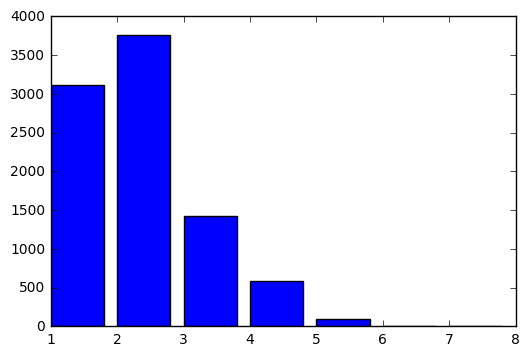

In [2]:
stat = df.groupby('room').size()
print stat.index
plt.bar(stat.index,stat.values)

From the figure above, we can see that most houses for rent are two beds and one bed room, while only a little has 6-8 beds houses for rent. 

### Average house prices for each house type

Here I will first group by house type and then calculate the avarage price for each type.

In [3]:
fun = lambda x: float(x[1:]) if x[0] == '$' else float(x)
df['price'] = df['price'].map(fun)
fun = lambda x: float(x[:-2]) if x[-2:] == 'ft' else float(x)
df['area'] = df['area'].map(fun)
df['datetime'] = df['datetime'].map(lambda x: x[:10])
df['datetime'] = pd.to_datetime(df['datetime'])

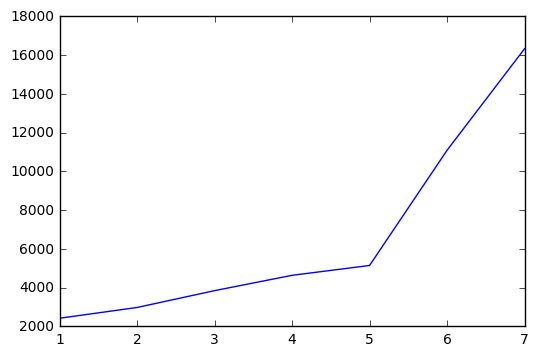

In [4]:
avg = df[['price','room']].groupby('room')['price'].mean()
plt.plot(avg.index,avg.values)

From this diagram, we can see at first the relationship between distance and time is linear when bedroom numbers are smaller than 4. However, when there are 4-5 bedrooms, the average house rent prices are similar. When it comes to 6-bed and 7-bed, there is a huge rise. Since there are only a few 6-bed and 7-bed apt samples, the statistical results for 6-7 bedrooms are not typical.

### Houses price per feet versus the corresponding post date diagram

Here, I will draw a diagram and investigate for each bedroom type, houses price price per feet versus the house rent start date trend. 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


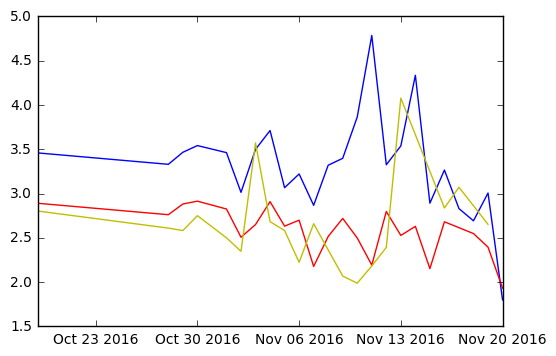

In [5]:
def plot_bedrooms(df, bd, style):
    df1b = df[df['room'] == str(bd)]
    price_ft = df1b['price'] / df1b['area']
    df1b['unitprice'] = price_ft
    df1b = df1b[df1b['unitprice'] < 20]
    mean_df = df1b.groupby('datetime').mean()
    plt.plot(mean_df.index, mean_df['unitprice'], style)

plot_bedrooms(df, 1, 'b')
plot_bedrooms(df, 2, 'r')
plot_bedrooms(df, 3, 'y')

From the above diagram, we can see, one bedroom house price is higher than 2-bedroom and 3-bedroom house. House price fluctuates when houses are going to rent in month.